In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import rawpy as raw
from peakutils import peak
from scipy import integrate, interpolate as interp, signal as sig, stats as stat
from jupyterthemes import jtplot

In [2]:
jtplot.reset()
# plt.switch_backend('nbAgg')
plt.style.use("seaborn")
plt.rcParams["axes.axisbelow"] = True
plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams["figure.figsize"] = (16/2, 9/2)
plt.rcParams["figure.dpi"] = 100
plt.rcParams["text.latex.preamble"] = [r"\usepackage{physics}", r"\usepackage{url}"]

## Mercury

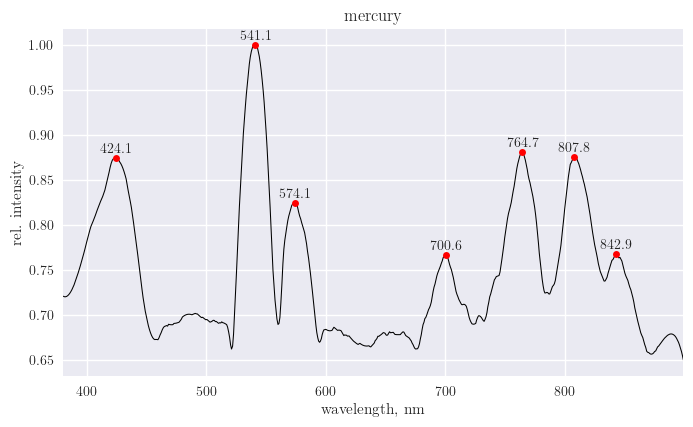

In [3]:
wavelength, intensity = np.genfromtxt('mercury.txt', unpack=True)
intensity = sig.savgol_filter(intensity, 51, 3)
intensity /= intensity.max()

pk = peak.indexes(intensity, thres=0.3, min_dist=20)

plt.plot(wavelength, intensity, 'k-', lw=0.75)
plt.plot(wavelength[pk], intensity[pk], 'ro', ms=5)
plt.xlabel('wavelength, nm')
plt.ylabel('rel. intensity')
plt.title('mercury')
for p in pk:
    plt.text(wavelength[p], intensity[p]+0.01,
             str(wavelength[p]),
             horizontalalignment='center',
             verticalalignment='center')
plt.xlim(wavelength.min(), wavelength.max())
# plt.ylim(0, 0.22)
plt.show()

In [11]:
Hg_raw = raw.imread('raw/_kvd7130.nef')
Hg = Hg_raw.postprocess(use_camera_wb=True,
                        output_bps=8,
                        no_auto_bright=True)
# Hg = cv.resize(Hg, (4000, 6000))

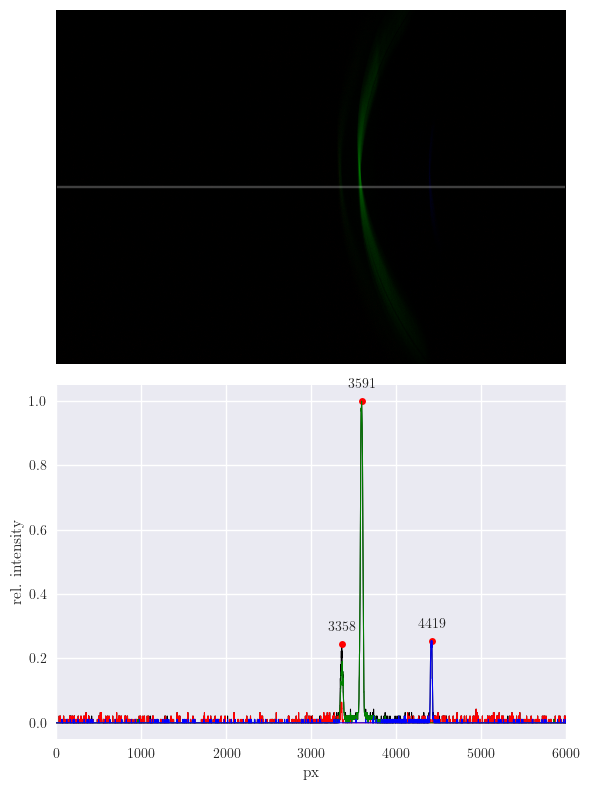

In [12]:
fig, ax = plt.subplots(2, 1, figsize=(6, 8))

ax[0].imshow(Hg, aspect='auto')
linescan = (Hg.shape[0]//2, Hg.shape[1]-16)
ax[0].hlines(linescan[0], 0, linescan[1], 'w', alpha=0.25)
ax[0].axis('off')

int_profile = (Hg.sum(axis=-1)[Hg.shape[0]//2]).astype(float)
pk = peak.indexes(int_profile, thres=0.2, min_dist=15)
ax[1].plot(int_profile/int_profile.max(), 'k', lw=0.75)
ax[1].plot(pk, int_profile[pk]/int_profile.max(), 'ro', ms=5)
for i, c in zip(range(Hg.shape[2]), ['r', 'g', 'b']):
    ax[1].plot(Hg[linescan[0], :, i]/int_profile.max(), color=c, lw=0.75)
for p in pk:
    plt.text(p, int_profile[p]/int_profile.max()+0.05,
             str(p),
             horizontalalignment='center',
             verticalalignment='center')
ax[1].set_xlim(0, Hg.shape[1]-16)
ax[1].set_xlabel('px')
ax[1].set_ylabel('rel. intensity')

plt.tight_layout()
plt.show()

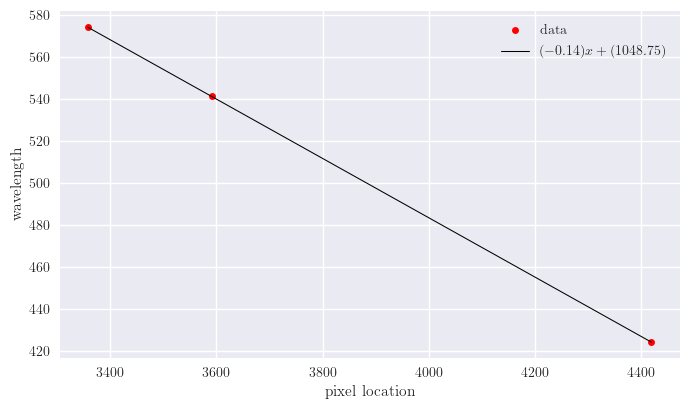

In [13]:
Hg_loc = np.array([3358, 3591, 4419])
Hg_lambda = np.array([574.1, 541.1, 424.1])

m, b, _, _, _ = stat.linregress(Hg_loc, Hg_lambda)

def cal(px):
    return m*px + b

plt.plot(Hg_loc, Hg_lambda, 'ro', ms=5, label='data')
plt.plot(Hg_loc, m*Hg_loc + b, 'k-', lw=0.75, label=r'$(%.2f)x + (%.2f)$'%(m, b))
plt.xlabel('pixel location')
plt.ylabel('wavelength')
plt.legend()
plt.show()

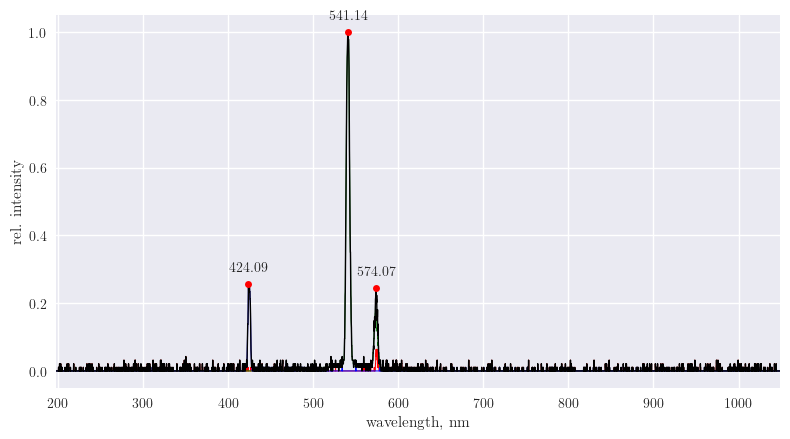

In [14]:
int_profile = Hg.sum(axis=-1)[Hg.shape[0]//2]
pk = peak.indexes(int_profile.astype(int), thres=0.2, min_dist=15)
wavelength = cal(np.arange(Hg.shape[1]))
for i, c in zip(range(Hg.shape[2]), ['r', 'g', 'b']):
    plt.plot(wavelength, Hg[linescan[0], :, i]/int_profile.max(), color=c, lw=0.75)
plt.plot(wavelength, int_profile/int_profile.max(), 'k', lw=1)
plt.plot(wavelength[pk], int_profile[pk]/int_profile.max(), 'ro', ms=5)
plt.xlim(wavelength.min(), wavelength.max())
plt.xlabel('wavelength, nm')
plt.ylabel('rel. intensity')
for p in pk:
    plt.text(wavelength[p], int_profile[p]/int_profile.max()+0.05,
             '%.2f'%(wavelength[p]),
             horizontalalignment='center',
             verticalalignment='center')
plt.tight_layout()
plt.show()

## Broad

In [15]:
white = cv.imread('_KVD7130.png')
white = cv.cvtColor(white, cv.COLOR_BGR2RGB)

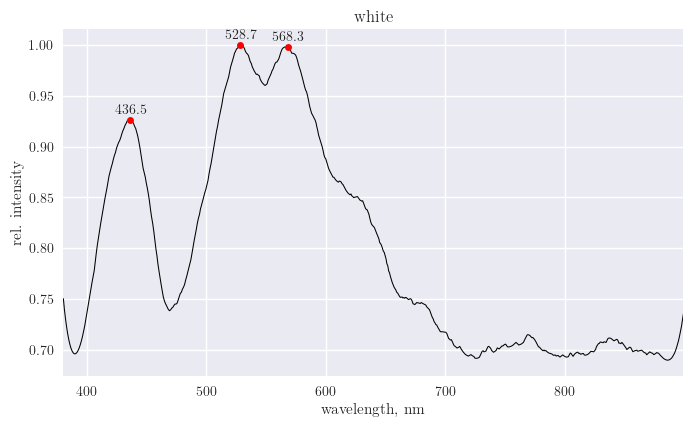

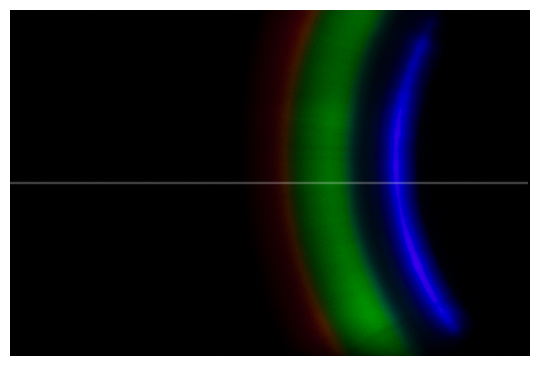

In [16]:
wavelength, intensity = np.genfromtxt('iphone_white.txt', unpack=True)
intensity = sig.savgol_filter(intensity, 51, 3)
intensity /= intensity.max()

pk = peak.indexes(intensity, thres=0.7, min_dist=30)

plt.plot(wavelength, intensity, 'k-', lw=0.75)
plt.plot(wavelength[pk], intensity[pk], 'ro', ms=5)
plt.xlabel('wavelength, nm')
plt.ylabel('rel. intensity')
plt.title('white')
for p in pk:
    plt.text(wavelength[p], intensity[p]+0.01,
             str(wavelength[p]),
             horizontalalignment='center',
             verticalalignment='center')
plt.xlim(wavelength.min(), wavelength.max())
# plt.ylim(0, 0.22)
plt.show()

linescan = (white.shape[0]//2, white.shape[1]-16)
plt.hlines(linescan[0], 0, linescan[1], 'w', alpha=0.25)
plt.imshow(white)
plt.axis('off')
plt.show()

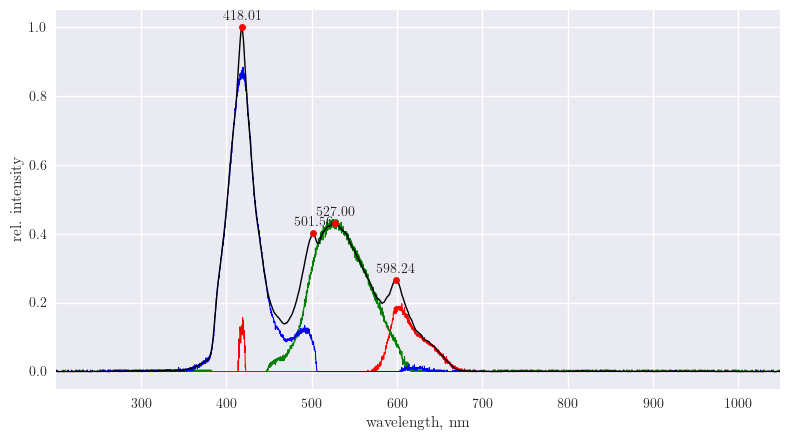

In [17]:
int_profile = white.sum(axis=-1)[Hg.shape[0]//2]
int_profile = sig.savgol_filter(int_profile, 71, 3)
pk = peak.indexes(int_profile.astype(int), thres=0.25, min_dist=30)
wavelength = cal(np.arange(white.shape[1]))
for i, c in zip(range(Hg.shape[2]), ['r', 'g', 'b']):
    plt.plot(wavelength, white[linescan[0], :, i]/int_profile.max(), color=c, lw=0.75)
plt.plot(wavelength, int_profile/int_profile.max(), 'k', lw=1)
plt.plot(wavelength[pk], int_profile[pk]/int_profile.max(), 'ro', ms=5)
plt.xlim(wavelength.min(), wavelength.max())
plt.xlabel('wavelength, nm')
plt.ylabel('rel. intensity')
for p in pk:
    plt.text(wavelength[p], int_profile[p]/int_profile.max()+0.03,
             '%.2f'%(wavelength[p]),
             horizontalalignment='center',
             verticalalignment='center')
plt.tight_layout()
plt.show()

In [18]:
cap = cv.VideoCapture('raw/KVD_7135.MOV')
dark = np.zeros((int(cap.get(cv.CAP_PROP_FRAME_HEIGHT)), int(cap.get(cv.CAP_PROP_FRAME_WIDTH)), 3))
frames = int(cap.get(cv.CAP_PROP_FRAME_COUNT))
count = 0
while True:
    ret, frame = cap.read()
    if not ret:
        break
    if count >= frames-250:
        dark += frame
    count += 1
dark /= frames
dark = dark.astype('float32')
dark = cv.resize(dark, (white.shape[:2]))

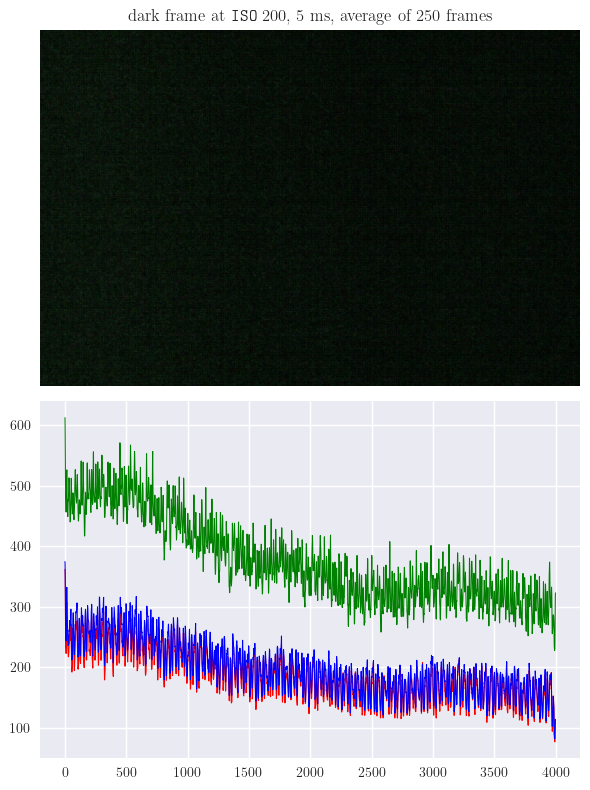

In [19]:
fig, ax = plt.subplots(2, 1, figsize=(6, 8))

ax[0].imshow(dark, aspect='auto')
ax[0].set_title(r'dark frame at \texttt{ISO} 200, 5 ms, average of 250 frames')
ax[0].axis('off')

for i, c in zip(range(3), ['r', 'g', 'b']):
    ax[1].plot(dark[:,:,i].sum(axis=0), color=c, lw=0.75)

plt.tight_layout()    
plt.show()